In [416]:
import pickle
import numpy as np
import pandas as pd

import torch
import json
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from embedding import BertHuggingface
from geometrical_bias import SAME, WEAT, GeneralizedWEAT, DirectBias, MAC, normalize, cossim, EmbSetList, EmbSet, GeometricBias
from utils import CLFHead, SimpleCLFHead, CustomModel, JigsawDataset, BiosDataset, DebiasPipeline

## TODO
- (x) save results
- save embeddings per dataset + model name
- optimize cosine scores (apply row/col wise to numpy array of embeddings? instead of list comprehension)
- (x) configs for everything (-> set up separate experiment with CLFHead)
- (yes) are splits reproucible with the same random_state?
- roc AUC
- jigsaw dataset
- adaptions for jigsaw dataset -> or other file?
- (get llama models working)


In [237]:
with open('data/protected_groups.json', 'r') as f:
    pg_config = json.load(f)
    
with open('configs/bios_exp2.json', 'r') as f:
    exp_config = json.load(f)
    
with open(exp_config['batch_size_lookup'], 'r') as f:
    batch_size_lookup = json.load(f)
    
groups_by_bias_types = pg_config['groups_by_bias_types']
terms_by_groups = pg_config['terms_by_groups']

cosine_scores = {'SAME': SAME, 'WEAT': WEAT, 'gWEAT': GeneralizedWEAT, 'DirectBias': DirectBias, 'MAC': MAC}
optimizer = {'RMSprop': torch.optim.RMSprop, 'Adam': torch.optim.Adam}
criterions = {'BCEWithLogitsLosss': torch.nn.BCEWithLogitsLoss, 'MultiLabelSoftMarginLoss': torch.nn.MultiLabelSoftMarginLoss}

bios_merged_file = '../MeasuringFairnessWithBiasedData/data/BIOS_REVIEWED.pkl'
titles = ['architect', 'psychologist', 'professor', 'photographer', 'journalist', 'attorney', 'teacher', 'dentist', '*software architect', '*writer', 'surgeon', 
                       'physician', 'nurse', '*researcher']
n_classes = len(titles)

In [83]:
bios_dataset = BiosDataset(n_folds=exp_config['n_fold'], sel_labels=exp_config['bios_classes'], bios_file=exp_config['bios_file'])


In [85]:
bios_dataset.set_data_split(0)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,65,75,60,251,220,171,101,22,31,83,193,140,10,26
female,20,126,34,130,149,107,160,15,3,97,16,81,121,14


In [86]:
bios_dataset.set_data_split(1)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,55,78,56,241,186,192,106,22,38,84,193,162,10,37
female,18,112,43,122,162,102,151,11,6,91,33,90,124,20


In [87]:
bios_dataset.set_data_split(2)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,65,77,52,241,214,166,117,23,28,106,190,166,4,41
female,18,103,43,111,200,103,148,10,2,99,25,85,110,12


In [88]:
bios_dataset.set_data_split(3)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,54,77,48,218,168,197,96,15,40,92,196,165,15,38
female,20,132,53,115,181,116,147,14,1,90,21,93,120,17


In [89]:
bios_dataset.set_data_split(4)

sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.eval_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
df

,architect,psychologist,professor,photographer,journalist,attorney,teacher,dentist,*software architect,*writer,surgeon,physician,nurse,*researcher
male,41,90,55,254,192,168,115,22,34,74,187,136,10,36
female,18,122,39,117,182,116,163,11,5,91,18,85,127,20


In [ ]:
bios_dataset2 = BiosDataset(n_folds=exp_config['n_fold'], sel_labels=titles, bios_file=bios_merged_file)
bios_dataset2.set_data_split(0)

In [ ]:
ids = [sample['id'] for sample in bios_dataset.train_data]
ids2 = [sample['id'] for sample in bios_dataset2.train_data]
ids == ids2

In [ ]:
lm = BertHuggingface(model_name='bert-base-uncased', batch_size=16, num_labels=len(titles))

In [9]:
bios_emb_all = lm.embed([sample['text'] for sample in bios_dataset.sel_data])

In [11]:
train_ids = [sample['id'] for sample in bios_dataset.train_data]
emb = [bios_emb_all[i] for i in train_ids]
X = [sample['text'] for sample in bios_dataset.train_data]
y = [sample['label'] for sample in bios_dataset.train_data]
groups = [sample['group'] for sample in bios_dataset.train_data]

lrs = [1e-03]
optimizers = ['Adam', 'RMSprop']
losses = ['BCEWithLogitsLoss']#, 'MultiLabelSoftMarginLoss']
epochs = [2, 5, 10, 20]
batch_sizes = [8]#, 16, 32, 64]

In [ ]:
for ep in epochs:
    for optim in optimizers:
        for loss in losses:
            for lr in lrs:
                for bs in batch_sizes:
                    params = {'optimizer': optim, 'criterion': loss, 'lr': lr, 'batch_size': bs, 'epochs': ep}
                    print(params)
                    head = CLFHead(input_size=lm.model.config.hidden_size, output_size=n_classes, hidden_size=lm.model.config.hidden_size)
                    pipeline = DebiasPipeline(params, head, debias=False)

                    # fit the whole pipeline
                    pipeline.fit(emb, y, epochs=params['epochs'], optimize_theta=True, group_label=groups)

In [ ]:
for ep in epochs:
    for optim in optimizers:
        for loss in losses:
            for lr in lrs:
                for bs in batch_sizes:
                    params = {'optimizer': optim, 'criterion': loss, 'lr': lr, 'batch_size': bs, 'epochs': ep}
                    print(params)
                    head = SimpleCLFHead(input_size=lm.model.config.hidden_size, output_size=n_classes)
                    pipeline = DebiasPipeline(params, head, debias=False)

                    # fit the whole pipeline
                    pipeline.fit(emb, y, epochs=params['epochs'], optimize_theta=True, group_label=groups)

## Evaluation
- check if debias reduces extrinsic biases
- plot correlation (job-wise vs. overall)
- cosine scores on train or eval data?

In [440]:
with open('configs/bios_exp1.json', 'r') as f:
    exp_config = json.load(f)

save_file = exp_config['save_file'] #results/bios1/res.pickle' #res_bios.pickle
with open(save_file, 'rb') as handle:
    res = pickle.load(handle)
    exp_parameters = res['params']
    results = res['results']
    #results_test = res['results_eval']

In [441]:
results[0].keys()

dict_keys(['id', 'extrinsic', 'extrinsic_individual', 'subgroup_AUC', 'BPSN', 'BNSP', 'SAME', 'SAME_individual', 'WEAT', 'WEAT_individual', 'gWEAT', 'gWEAT_individual', 'DirectBias', 'DirectBias_individual', 'MAC', 'MAC_individual', 'recall', 'precision', 'f1', 'class_recall'])

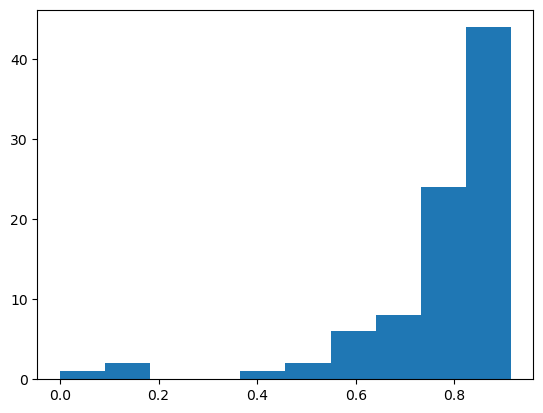

In [442]:
recalls = [res['recall'] for res in results]
counts, bins = np.histogram(recalls)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [428]:
cur_model = ""
for i, res in enumerate(results):
    if exp_parameters[i]['embedder'] != cur_model:
        cur_model = exp_parameters[i]['embedder']
        print()
        print(cur_model)
    if res['recall'] > 0.5 and min(res['class_recall']) > 0.05:
        continue
    if exp_parameters[i]['debias']:
        print(exp_parameters[i]['lr'], exp_parameters[i]['debias'], exp_parameters[i]['debias_k'])
    else:
        print(exp_parameters[i]['lr'], exp_parameters[i]['debias'])
    #print(res['recall'])
    #print(res['class_recall'])
    


bert-base-uncased
[0.001, 0.0001, 1e-05] True 5

bert-large-uncased
[0.001, 0.0001, 1e-05] False
[0.001, 0.0001, 1e-05] True 3

distilbert-base-uncased
[0.001, 0.0001, 1e-05] False

roberta-base
[0.001, 0.0001, 1e-05] True 7

roberta-large
[0.001, 0.0001, 1e-05] True 3
[0.001, 0.0001, 1e-05] True 5
[0.001, 0.0001, 1e-05] True 7

distilroberta-base
[0.001, 0.0001, 1e-05] True 3
[0.001, 0.0001, 1e-05] True 5
[0.001, 0.0001, 1e-05] True 7

xlm-roberta-base
[0.001, 0.0001, 1e-05] True 3
[0.001, 0.0001, 1e-05] True 5
[0.001, 0.0001, 1e-05] True 7

albert-base-v2

albert-large-v2
[0.001, 0.0001, 1e-05] True 5

google/electra-base-generator
[0.001, 0.0001, 1e-05] True 7

google/electra-large-generator

bert-base-multilingual-uncased
[0.001, 0.0001, 1e-05] True 7

GroNLP/hateBERT
[0.001, 0.0001, 1e-05] False
[0.001, 0.0001, 1e-05] True 3
[0.001, 0.0001, 1e-05] True 7

Twitter/twhin-bert-base
[0.001, 0.0001, 1e-05] True 5
[0.001, 0.0001, 1e-05] True 7

medicalai/ClinicalBERT
[0.001, 0.0001, 1e

In [429]:
score_list = list(cosine_scores.keys())+['extrinsic']
scores_per_bias_type = {bt : {score: [] for score in score_list+['subgroup_AUC', 'BNSP', 'BPSN']} for bt in exp_config['bias_types']}
class_wise_scores = {score: [] for score in score_list}
for i in range(len(results)):
    print("experiment", i, "with bias type", exp_parameters[i]['bias_type'], "and", exp_parameters[i]['embedder'])
    
    if results[i]['recall'] < 0.5 or np.min(results[i]['class_recall']) < 0.05:
        print("skip because recall < 0.3")
        continue
    for score in score_list:
        scores_per_bias_type[exp_parameters[i]['bias_type']][score].append(results[i][score])
    for score in ['subgroup_AUC', 'BNSP', 'BPSN']:
        scores_per_bias_type[exp_parameters[i]['bias_type']][score].append(np.mean(results[i][score], axis=1))
    
    for score in score_list:
        if score == 'gWEAT':
            continue
        for score2 in score_list:
            if score == score2 or score2 == 'gWEAT':
                continue
                
            # class-wise bias scores
            scores1 = np.abs(np.mean(results[i][score+'_individual'], axis=0))
            scores2 = np.abs(np.mean(results[i][score2+'_individual'], axis=0))
            class_wise_scores[score].append(scores1)
            try:
                slope, intercept, r, p, std_err = scipy.stats.linregress(scores1, scores2)
            except ValueError:
                print("invalid values for ", score, score2)
                print(results[i]['recall'])
            if 'extrinsic' in score and p < 0.1:
                print(score, score2, "R="+str(r)+" (p="+str(p)+")")
    print()
    print()

experiment 0 with bias type gender and bert-base-uncased
extrinsic WEAT R=-0.5904433686093735 (p=0.026212943512412684)


experiment 1 with bias type gender and bert-base-uncased


experiment 2 with bias type gender and bert-base-uncased
skip because recall < 0.3
experiment 3 with bias type gender and bert-base-uncased


experiment 4 with bias type gender and bert-large-uncased
skip because recall < 0.3
experiment 5 with bias type gender and bert-large-uncased
skip because recall < 0.3
experiment 6 with bias type gender and bert-large-uncased


experiment 7 with bias type gender and bert-large-uncased
extrinsic DirectBias R=-0.46210391985588695 (p=0.0961994636001591)


experiment 8 with bias type gender and distilbert-base-uncased
skip because recall < 0.3
experiment 9 with bias type gender and distilbert-base-uncased


experiment 10 with bias type gender and distilbert-base-uncased
extrinsic SAME R=0.5395320673845055 (p=0.04645519037535662)


experiment 11 with bias type gender and dis

gender
SAME


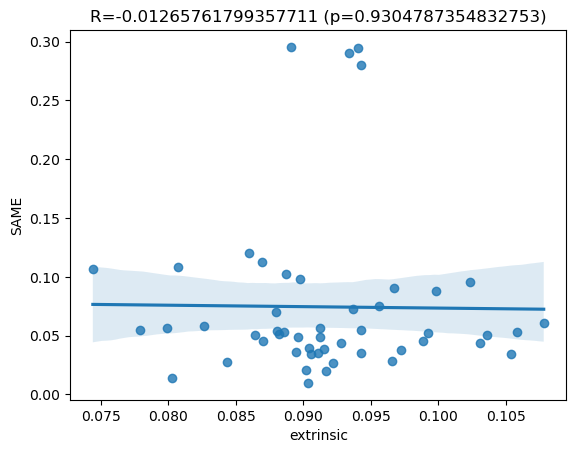


WEAT


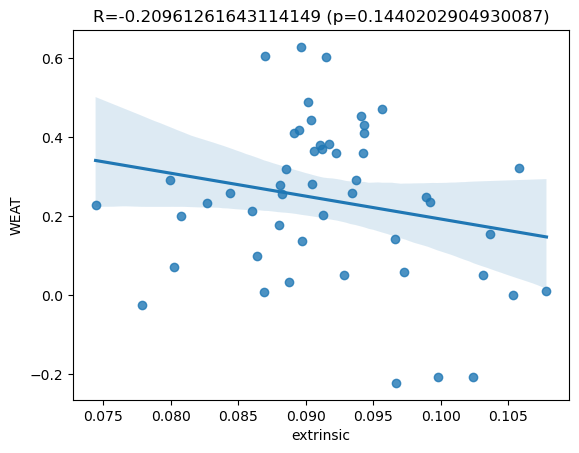


gWEAT


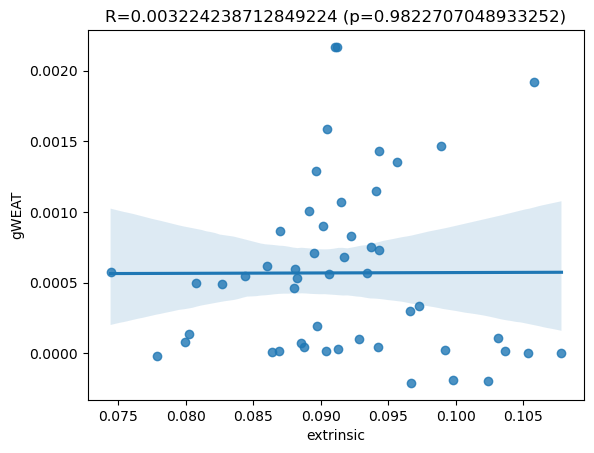


DirectBias


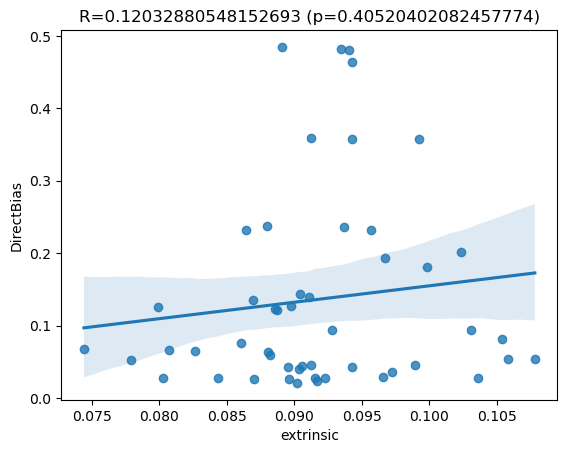


MAC


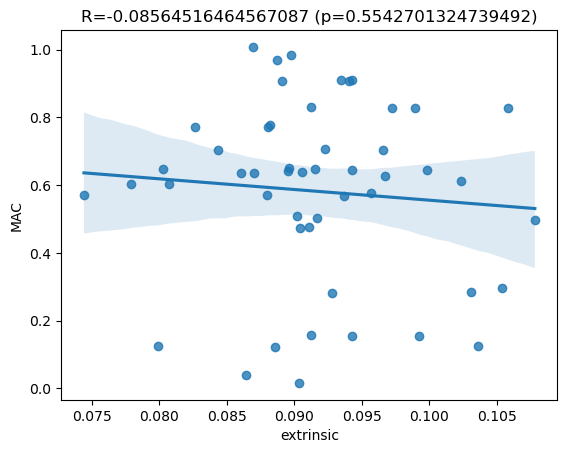


gender
SAME


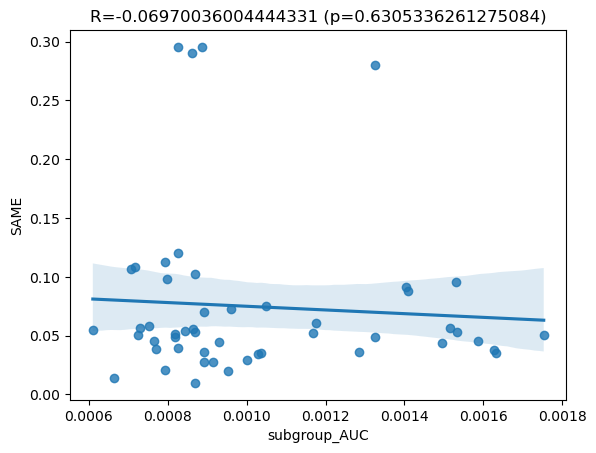


WEAT


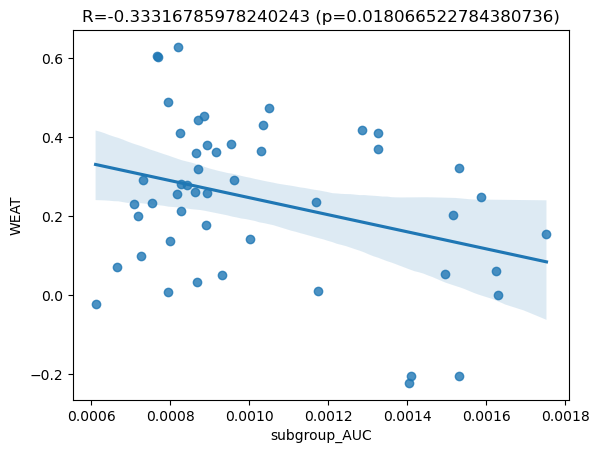


gWEAT


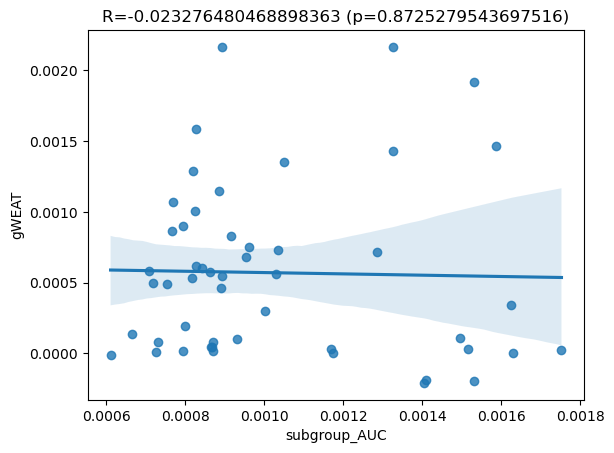


DirectBias


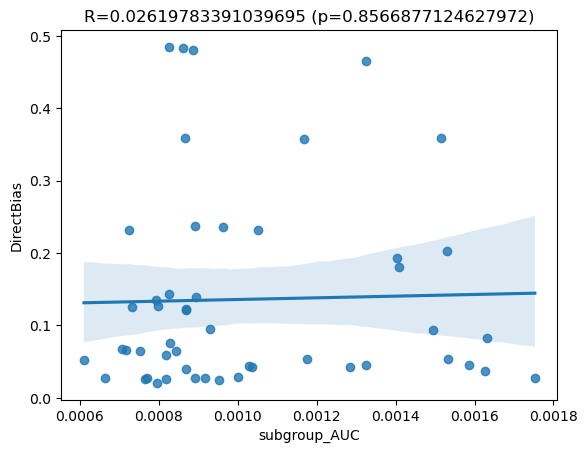


MAC


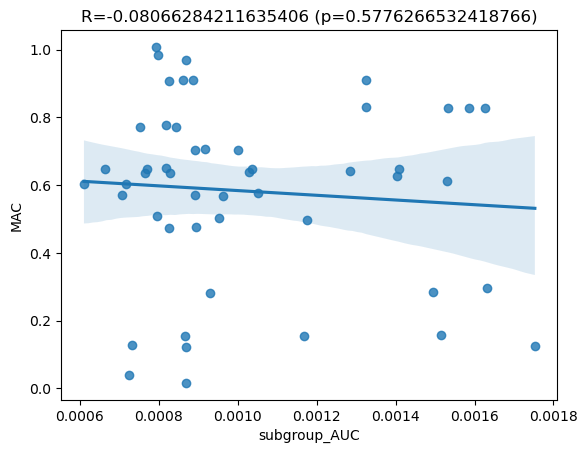


gender
SAME


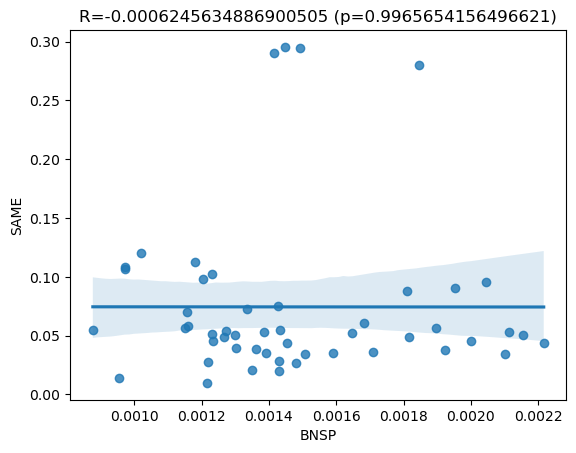


WEAT


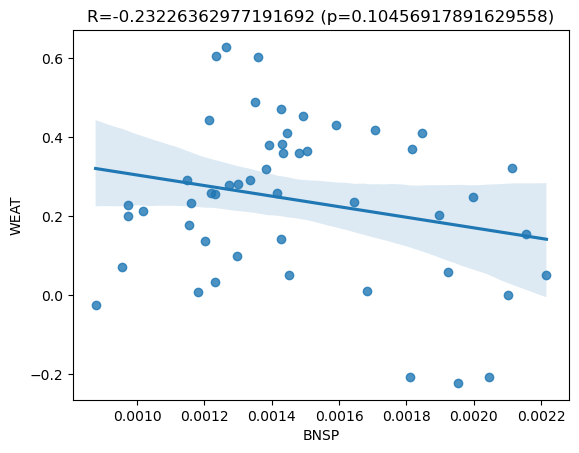


gWEAT


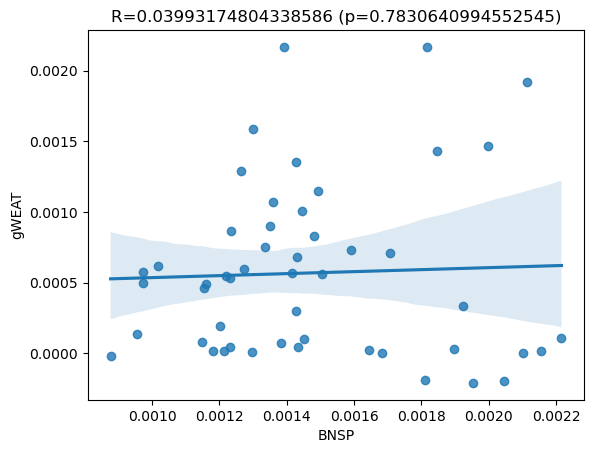


DirectBias


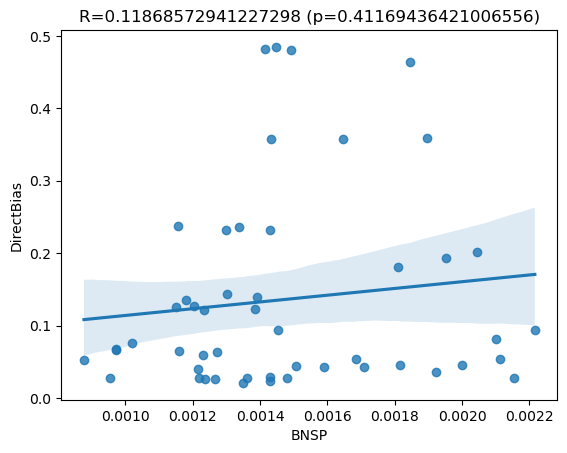


MAC


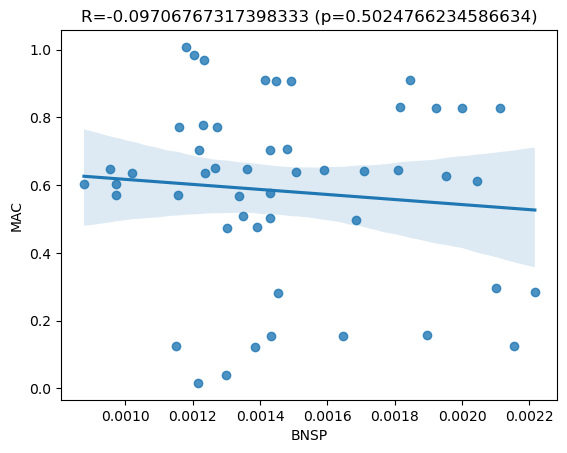


gender
SAME


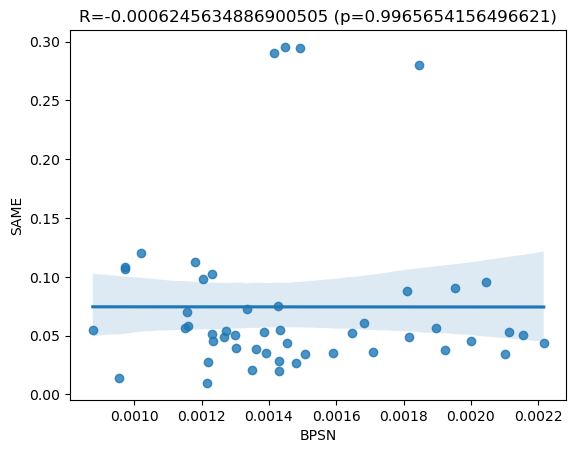


WEAT


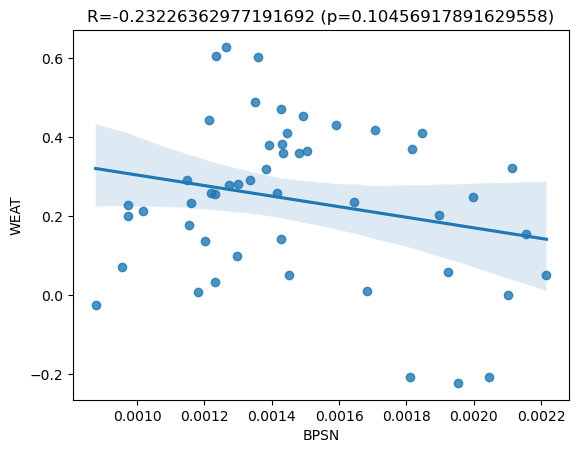


gWEAT


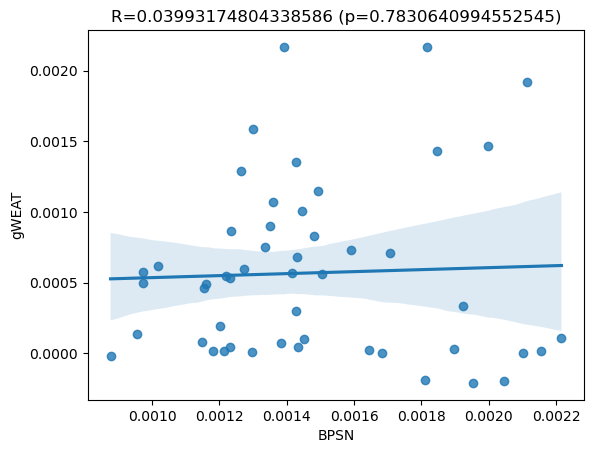


DirectBias


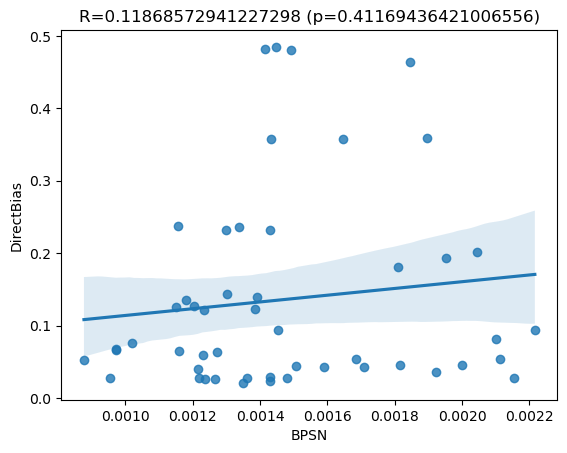


MAC


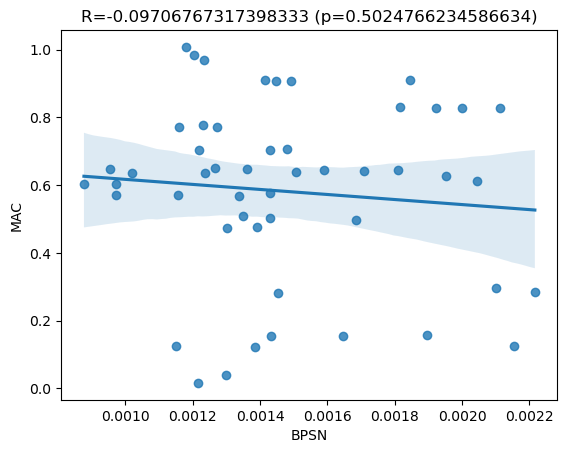

In [430]:
mean_scores = {}
for bt, res in scores_per_bias_type.items():
    mean_scores[bt] = {score: np.mean(scores_per_bias_type[bt][score], axis=1) for score in score_list+['subgroup_AUC', 'BNSP', 'BPSN']}

for comp in ['extrinsic', 'subgroup_AUC', 'BNSP', 'BPSN']:
    for bt, res in mean_scores.items():
        df = pd.DataFrame(res)
        print(bt)
        for score in score_list:
            if not score == 'extrinsic':
                print(score)
                slope, intercept, r, p, std_err = scipy.stats.linregress(df.loc[:,comp], df.loc[:,score])
                #print(r, p)
                sns.regplot(x=comp, y=score, data=df).set_title("R="+str(r)+" (p="+str(p)+")")
                plt.show()
                print()

In [ ]:
n_classes = class_wise_scores['SAME'][0].shape[0]
stacked_scores = {c: {} for c in range(n_classes)}
for score in score_list:
    if not score == 'gWEAT':
        for c in range(n_classes):
            stacked_scores[c][score] = np.asarray(class_wise_scores[score])[:,c]

for c in range(n_classes):
    print(c)
    for score in stacked_scores[c].keys():
        print(score, len(stacked_scores[c][score]))
    df = pd.DataFrame(stacked_scores[c])
    for score in stacked_scores[0].keys():
        if not score == 'extrinsic':
            print(score)
            sns.regplot(x="extrinsic", y=score, data=df, label="class "+str(c))        
            plt.show()
    print()
    print()

In [443]:
debias_ks = exp_config['debias_k']
embedder = exp_config['embedders']

In [444]:
debias_ks

[3, 5, 7]

In [445]:
results[0]['SAME']

[0.05091303643504962,
 0.05204263908362517,
 0.051855186833042244,
 0.051731616772288685,
 0.0509661670233798]

In [446]:
results[3]['SAME']

[0.058529742087413565,
 0.05893905044939687,
 0.058547096103733966,
 0.05776667042656094,
 0.05739052390424896]

In [447]:
len(exp_parameters)

88

In [448]:
len(exp_parameters)

88

In [449]:
all_scores = list(cosine_scores.keys())+['extrinsic']
exp_idx = 0
bias_decreased = {score: {k: [] for k in debias_ks} for score in all_scores}
for model in embedder:
    low_recall = False
    for idx in range(exp_idx, exp_idx+len(debias_ks)):
        if results[idx]['recall'] < 0.3:
            low_recall = True
    if low_recall:
        print("skip ", model, "because of low recall")
        exp_idx += len(debias_ks)+1
        continue
        
    default_idx = exp_idx
    debias_ids = [exp_idx+i+1 for i,k in enumerate(debias_ks)]
    exp_idx += len(debias_ks)+1
    for score in all_scores:
        if score not in results[default_idx].keys():
            continue
        default_scores = results[default_idx][score] # one per split

        for i,k in enumerate(debias_ks):
            for i, fold in enumerate(results[debias_ids[i]][score]):
                bias_decreased[score][k].append(fold < default_scores[i])

print("percentage of experiments with decreased extrinsic biases after hard debiasing (per k):")
for score in all_scores:
    print(score)
    for k in debias_ks:
        print(k, np.sum(bias_decreased[score][k])/len(bias_decreased[score][k]))
    print()
        

skip  albert-xlarge-v2 because of low recall
skip  gpt2 because of low recall
skip  xlnet-base-cased because of low recall
percentage of experiments with decreased extrinsic biases after hard debiasing (per k):
SAME
3 0.47368421052631576
5 0.6210526315789474
7 0.6736842105263158

WEAT
3 0.3263157894736842
5 0.5578947368421052
7 0.6105263157894737

gWEAT
3 0.4421052631578947
5 0.6631578947368421
7 0.6842105263157895

DirectBias
3 0.42105263157894735
5 0.4
7 0.4421052631578947

MAC
3 0.9473684210526315
5 0.9368421052631579
7 0.9368421052631579

extrinsic
3 0.4
5 0.4842105263157895
7 0.5052631578947369



SAME
3


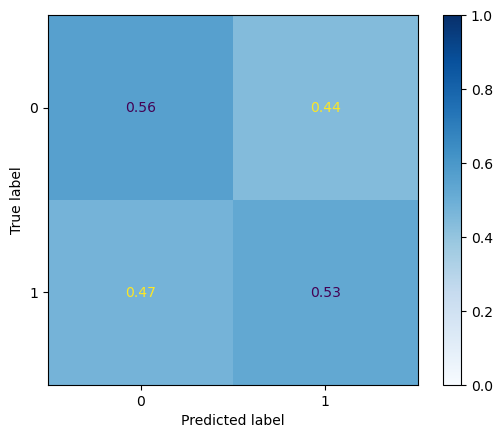

ROC AUC:  0.5438596491228069

5


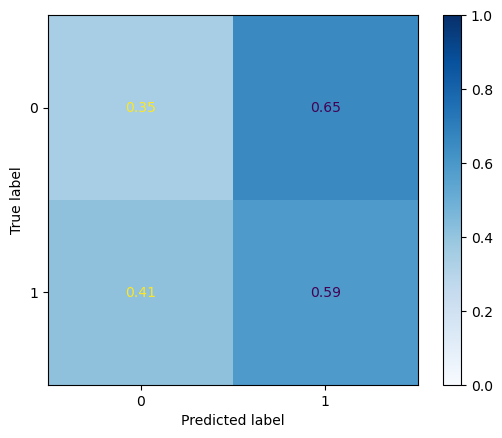

ROC AUC:  0.4669476486246673

7


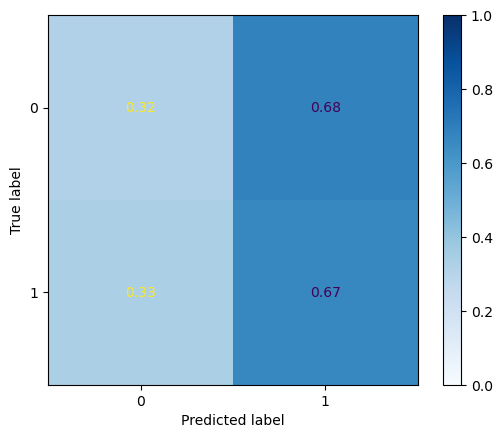

ROC AUC:  0.4929078014184397


WEAT
3


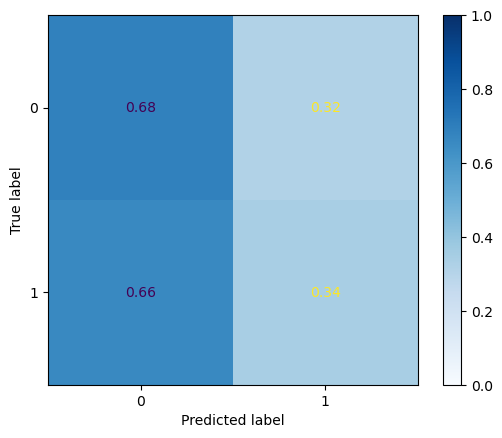

ROC AUC:  0.5131578947368421

5


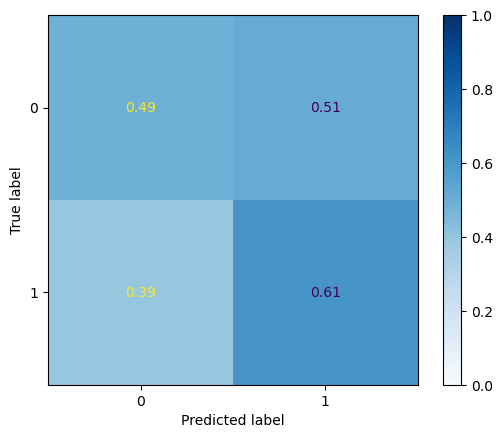

ROC AUC:  0.5492457852706301

7


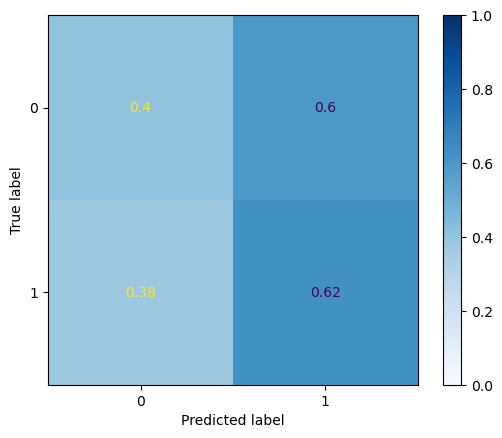

ROC AUC:  0.5146276595744681


gWEAT
3


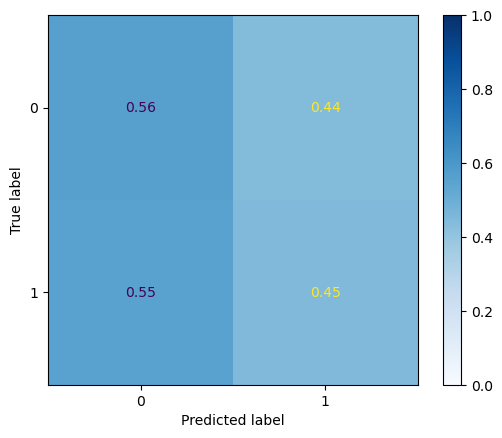

ROC AUC:  0.5043859649122807

5


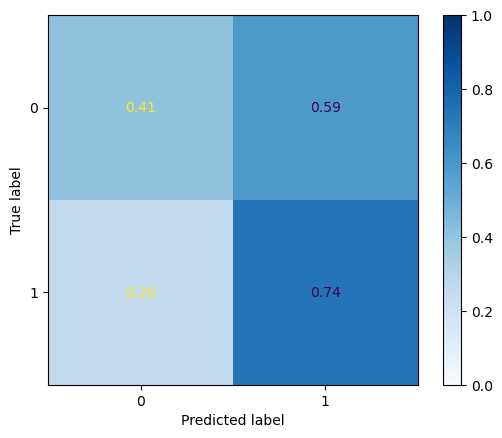

ROC AUC:  0.5736468500443656

7


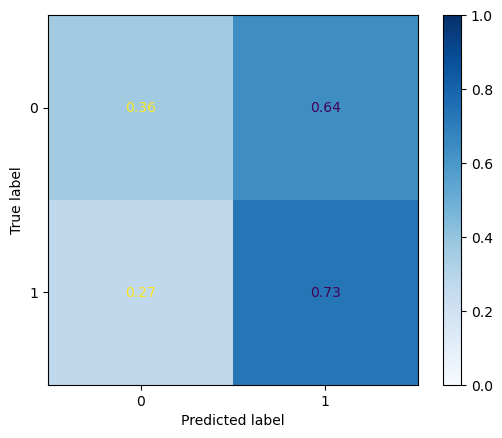

ROC AUC:  0.5454343971631205


DirectBias
3


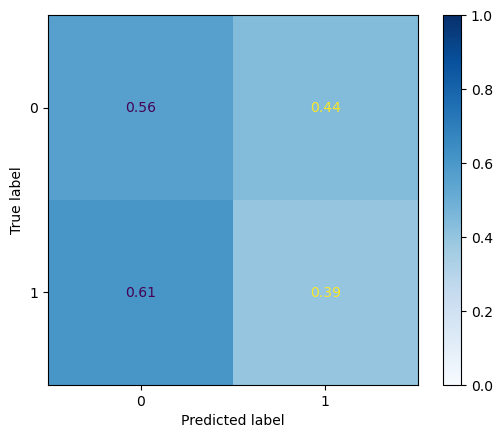

ROC AUC:  0.47807017543859653

5


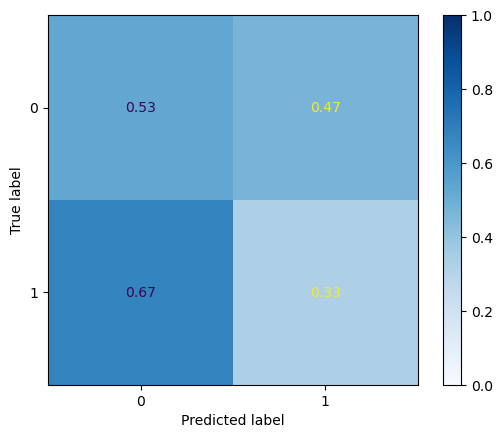

ROC AUC:  0.4283496007098492

7


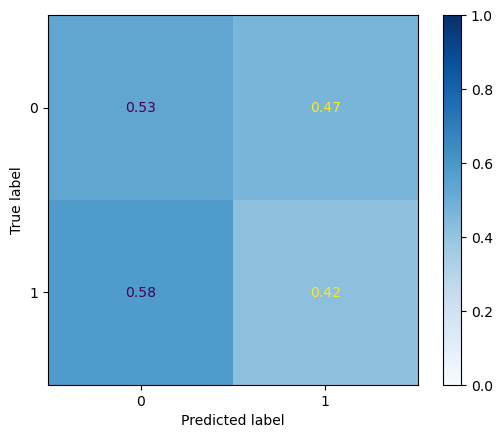

ROC AUC:  0.474290780141844


MAC
3


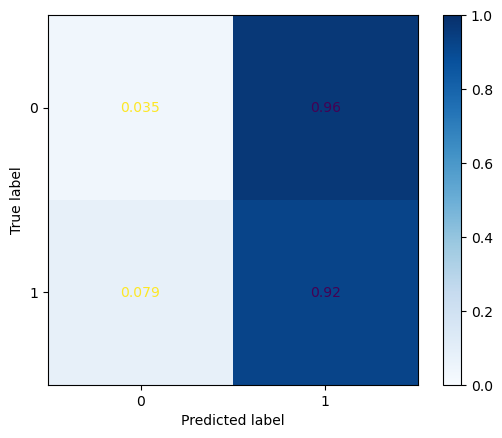

ROC AUC:  0.4780701754385965

5


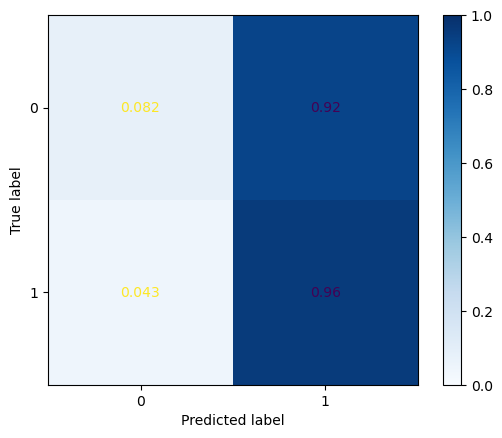

ROC AUC:  0.5190771960958296

7


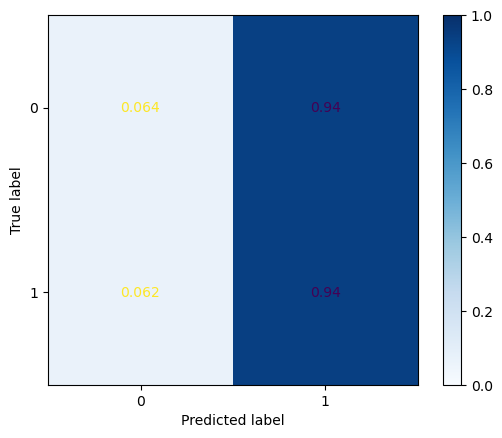

ROC AUC:  0.5006648936170213




In [450]:
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay

for score in cosine_scores.keys():
    print(score)
    for k in debias_ks:
        print(k)
        cm = confusion_matrix(bias_decreased['extrinsic'][k],bias_decreased[score][k], normalize='true')
        cm_display = ConfusionMatrixDisplay(cm).plot()
        cm_display.ax_.get_images()[0].set_clim(0, 1)
        cm_display.ax_.get_images()[0].set_cmap(plt.cm.Blues)
        plt.show()
        print("ROC AUC: ", roc_auc_score(bias_decreased['extrinsic'][k],bias_decreased[score][k]))
        #fpr, tpr, _ = roc_curve(bias_decreased['extrinsic'][k],bias_decreased[score][k])
        #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        print()
    print()

In [451]:
decrease_agree = {score: {k: [] for k in debias_ks} for score in cosine_scores}
for score in cosine_scores:
    exp_idx = 0
    for model in embedder:
        low_recall = False
        for idx in range(exp_idx, exp_idx+len(debias_ks)):
            if results[idx]['recall'] < 0.3:
                low_recall = True
        if low_recall:
            print("skip ", model, "because of low recall")
            exp_idx += len(debias_ks)+1
            continue
        default_scores_ex = results[exp_idx]['extrinsic'] # one per split
        default_scores_cos = results[exp_idx][score] # one per split
        exp_idx += 1

        for k in debias_ks:
            for i, fold in enumerate(results[exp_idx]['extrinsic']):
                extrinsic_decrease = fold < default_scores_ex[i]
                cosine_decrease = results[exp_idx][score][i] < default_scores_cos[i]
                decrease_agree[score][k].append(extrinsic_decrease == cosine_decrease)
            exp_idx += 1

print("how often scores agree with the extrinsic biases regarding the reduction of biases after debiasing:")
for score in cosine_scores:
    for k in debias_ks:
        print(score, k, np.sum(decrease_agree[score][k])/len(decrease_agree[score][k]))

skip  albert-xlarge-v2 because of low recall
skip  gpt2 because of low recall
skip  xlnet-base-cased because of low recall
skip  albert-xlarge-v2 because of low recall
skip  gpt2 because of low recall
skip  xlnet-base-cased because of low recall
skip  albert-xlarge-v2 because of low recall
skip  gpt2 because of low recall
skip  xlnet-base-cased because of low recall
skip  albert-xlarge-v2 because of low recall
skip  gpt2 because of low recall
skip  xlnet-base-cased because of low recall
skip  albert-xlarge-v2 because of low recall
skip  gpt2 because of low recall
skip  xlnet-base-cased because of low recall
how often scores agree with the extrinsic biases regarding the reduction of biases after debiasing:
SAME 3 0.5473684210526316
SAME 5 0.4631578947368421
SAME 7 0.49473684210526314
WEAT 3 0.5473684210526316
WEAT 5 0.5473684210526316
WEAT 7 0.5157894736842106
gWEAT 3 0.5157894736842106
gWEAT 5 0.5684210526315789
gWEAT 7 0.5473684210526316
DirectBias 3 0.49473684210526314
DirectBias 5 0